In [1]:
import numpy as np
import pandas as pd
import cv2

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import torch
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import time
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%run '/content/drive/MyDrive/obj_detect/tools.ipynb'
%run '/content/drive/MyDrive/obj_detect/models.ipynb'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
data_folder = f'{folder_path}pics/PennFudanPed/'

In [6]:
img_to_mask = lambda t: t[:t.find('.')] + '_mask' + '.png'

In [7]:
img_size = 288

In [8]:
image_folder = data_folder + 'PNGImages/'
image_files = os.listdir(image_folder)

mask_folder = data_folder + 'PedMasks/'
mask_files = os.listdir(mask_folder)

print(f'{len(image_files)} image files. {len(mask_files)} mask files.')

170 image files. 170 mask files.


In [9]:
load_np_train_sets = True
save_train_pics = False

In [10]:
if (not load_np_train_sets):
  image_num = 0
  images_length = len(image_files)

  np_X = []
  np_Y = []

  for i in image_files:
    if(not accept_img(i)): continue
    pic_path = image_folder + i
    # print(pic_path)

    image = cv2.imread(pic_path)
    mask_path = mask_folder + img_to_mask(i)
    # print(mask_path)

    mask = cv2.imread(mask_path)
    mask = mask * 255

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_size, img_size))
    # print(image.shape)

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (img_size, img_size))
    # print(mask.shape)

    np_X.append(image)
    np_Y.append(mask)
    image_num+=1

    if(image_num==images_length-1): print(f'{image_num+1}/{images_length} images and masks done.')
    elif ((image_num+1)%20==0): print(f'{image_num+1}/{images_length} images and masks done.')

    # break

  np_X = np.array(np_X)
  np_Y = np.array(np_Y)

  if (save_train_pics):
    np.save(f'{folder_path}train_sets/cross_walk_X_np.npy', np_X)
    np.save(f'{folder_path}train_sets/cross_walk_Y_np.npy', np_Y)
    print('Successfully saved train sets.')

else:
  np_X = np.load(f'{folder_path}train_sets/cross_walk_X_np.npy')
  np_Y = np.load(f'{folder_path}train_sets/cross_walk_Y_np.npy')
  print('Successfully loaded train sets.')

print(f'X shape {np_X.shape}. Y shape {np_Y.shape}.')

Successfully loaded train sets.
X shape (170, 288, 288, 3). Y shape (170, 288, 288).


In [11]:
torchX = torch.tensor(np_X.transpose(0, 3, 1, 2), dtype = torch.float32)
torchY = torch.tensor(np_Y, dtype = torch.float32)

torchX = torchX.to(device)
torchY = torchY.to(device)

print(f'Sample Input Tensor Shape {torchX[0].shape}.')

Sample Input Tensor Shape torch.Size([3, 288, 288]).


In [12]:
# create instance of CNN Image Classifier using pretrained model parameters
obj_detect = imgsegUnet(3, 1).to(device)

#optimizer, lr = learning rate
opt = Adam(obj_detect.parameters(), lr=1e-3)

#loss function
loss_fn = nn.MSELoss()

In [13]:
obj_detect.class_predictions_block

Sequential(
  (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [14]:
load_animal_model = False

In [15]:
if (load_animal_model):
  with open(f'{drive_path}obj_detect/saved_models/animal_segmentation_model_trained.pt', 'rb') as f:
          if(device == 'cpu'):
            obj_detect.load_state_dict(load(f, map_location=torch.device('cpu')))
            print(f'Successfully loaded animal model to {device}.')
          else:
            obj_detect.load_state_dict(load(f))
            print(f'Successfully loaded animal model to {device}.')
else:
  with open(f'{drive_path}obj_detect/saved_models/cross_walk_segmentation_model_trained.pt', 'rb') as f:
        if(device == 'cpu'):
          obj_detect.load_state_dict(load(f, map_location=torch.device('cpu')))
          print(f'Successfully loaded cross walk model to {device}.')
        else:
          obj_detect.load_state_dict(load(f))
          print(f'Successfully loaded cross walk model to {device}.')

Successfully loaded cross walk model to cuda.


In [16]:
# change output channels = 1
obj_detect.class_predictions_block[1] = nn.Conv2d(16, 1, kernel_size = (3,3), padding = 1)

In [17]:
obj_detect.class_predictions_block

Sequential(
  (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [18]:
obj_detect = obj_detect.to(device)

In [19]:
x_train, x_val, y_train, y_val = train_test_split(torchX, torchY, test_size=0.15, random_state=1245)

In [22]:
x_val.shape

torch.Size([26, 3, 288, 288])

In [36]:
num_epochs = 50
epoch_print_interval = 10
batch_size = 32

train_time = True
updateModel = False

In [41]:
# Training flow
if (train_time):

    type_out = f'Training Size is {len(x_train)}. Validation Size is {len(x_val)}. Batch Size is {batch_size}. Maximum Epochs is {num_epochs}.'
    print(type_out)
    for v in type_out: print('_', end ='')
    print()
    print()

    # create train set data loader
    train = []

    for k in range(len(x_train)):
        train.append((x_train[k], y_train[k]))

    trainloader = DataLoader(train, batch_size)

    # create validation data loader
    val = []

    for j in range(len(x_val)):
        val.append((x_val[j], y_val[j]))

    valloader = DataLoader(val, batch_size)

    start_time = time.time()
    for epoch in range(1, num_epochs+1):

        obj_detect.train()
        for batch in trainloader:

            x,y = batch

            x, y = x.to(device), y.to(device)
            # print(x, y)

            yhat = obj_detect(x).squeeze()
            # print(yhat.shape, y.shape)

            loss = loss_fn(yhat, y)

            # backpropogation
            opt.zero_grad()
            loss.backward()
            opt.step()

        obj_detect.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for batch in valloader:
                x, y = batch
                x, y = x.to(device), y.to(device)

                yhat = obj_detect(x).squeeze()
                vloss = loss_fn(yhat, y)

                val_loss += vloss.item()

        val_loss /= len(valloader)

        # print loss for epoch every so often
        if (epoch%epoch_print_interval==0):
          end_time = time.time()

          print(f"| Epoch {epoch} Training Batch Loss: {str(loss.item())[:6]} | Validation Batch Loss: {str(val_loss)[:6]} | Time: {str(end_time-start_time)[:4]} seconds |")
          start_time = time.time()

#     if (updateModel):
#         #save trained model into 'model_state.pt'
#         with open(f'{drive_path}obj_detect/saved_models/cross_walk_segmentation_model_trained.pt', 'wb') as f:
#             save(obj_detect.state_dict(), f)

#         print('Successfully updated model.')

# ________________________________________________________________________________________________________________________________________________________________
# else:
#   obj_detect = image_seg_UNet(3, 1).to(device)
#   with open(f'{drive_path}obj_detect/saved_models/cross_walk_segmentation_model_trained.pt', 'rb') as f:
#         if(device == 'cpu'):
#           obj_detect.load_state_dict(load(f, map_location=torch.device('cpu')))
#           print(f'Successfully loaded model to {device}.')
#         else:
#           obj_detect.load_state_dict(load(f))
#           print(f'Successfully loaded model to {device}.')

Training Size is 144. Validation Size is 26. Batch Size is 32. Maximum Epochs is 50.
____________________________________________________________________________________

| Epoch 10 Batch Loss: 32.197 | Validaton Batch Loss: 115.34 | Time: 9.25 seconds |
| Epoch 20 Batch Loss: 24.006 | Validaton Batch Loss: 112.65 | Time: 9.22 seconds |
| Epoch 30 Batch Loss: 21.455 | Validaton Batch Loss: 112.09 | Time: 9.23 seconds |
| Epoch 40 Batch Loss: 24.306 | Validaton Batch Loss: 111.61 | Time: 9.22 seconds |
| Epoch 50 Batch Loss: 21.228 | Validaton Batch Loss: 112.69 | Time: 9.22 seconds |


In [33]:
# updateModel = True
# if (updateModel):
#     #save trained model into 'model_state.pt'
#     with open(f'{drive_path}obj_detect/saved_models/cross_walk_segmentation_model_trained.pt', 'wb') as f:
#         save(obj_detect.state_dict(), f)

#     print('Successfully updated model.')

In [42]:
my_test_pics_folder = data_folder + 'test_images/'
my_test_pic_files = os.listdir(my_test_pics_folder)

In [43]:
test_np = []
for i in my_test_pic_files:
  if(not accept_img(i)): continue
  pic_path = my_test_pics_folder + i
  img = cv2.imread(pic_path)
  img = cv2.resize(img, (img_size, img_size))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  test_np.append(img)

test_np = np.array(test_np)
print(f'Test np shape {test_np.shape}.')

Test np shape (5, 288, 288, 3).


In [44]:
test_torch = torch.tensor(test_np.transpose(0, 3, 1, 2), dtype = torch.float32)
test_torch = test_torch.to(device)
print(f'Test torch shape {test_torch.shape}.')

Test torch shape torch.Size([5, 3, 288, 288]).


In [45]:
obj_detect.eval()
obj_detect.class_predictions_block

Sequential(
  (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [46]:
test_preds = obj_detect(test_torch).squeeze().to('cpu')

In [47]:
test_pred_np = test_preds.detach().numpy()

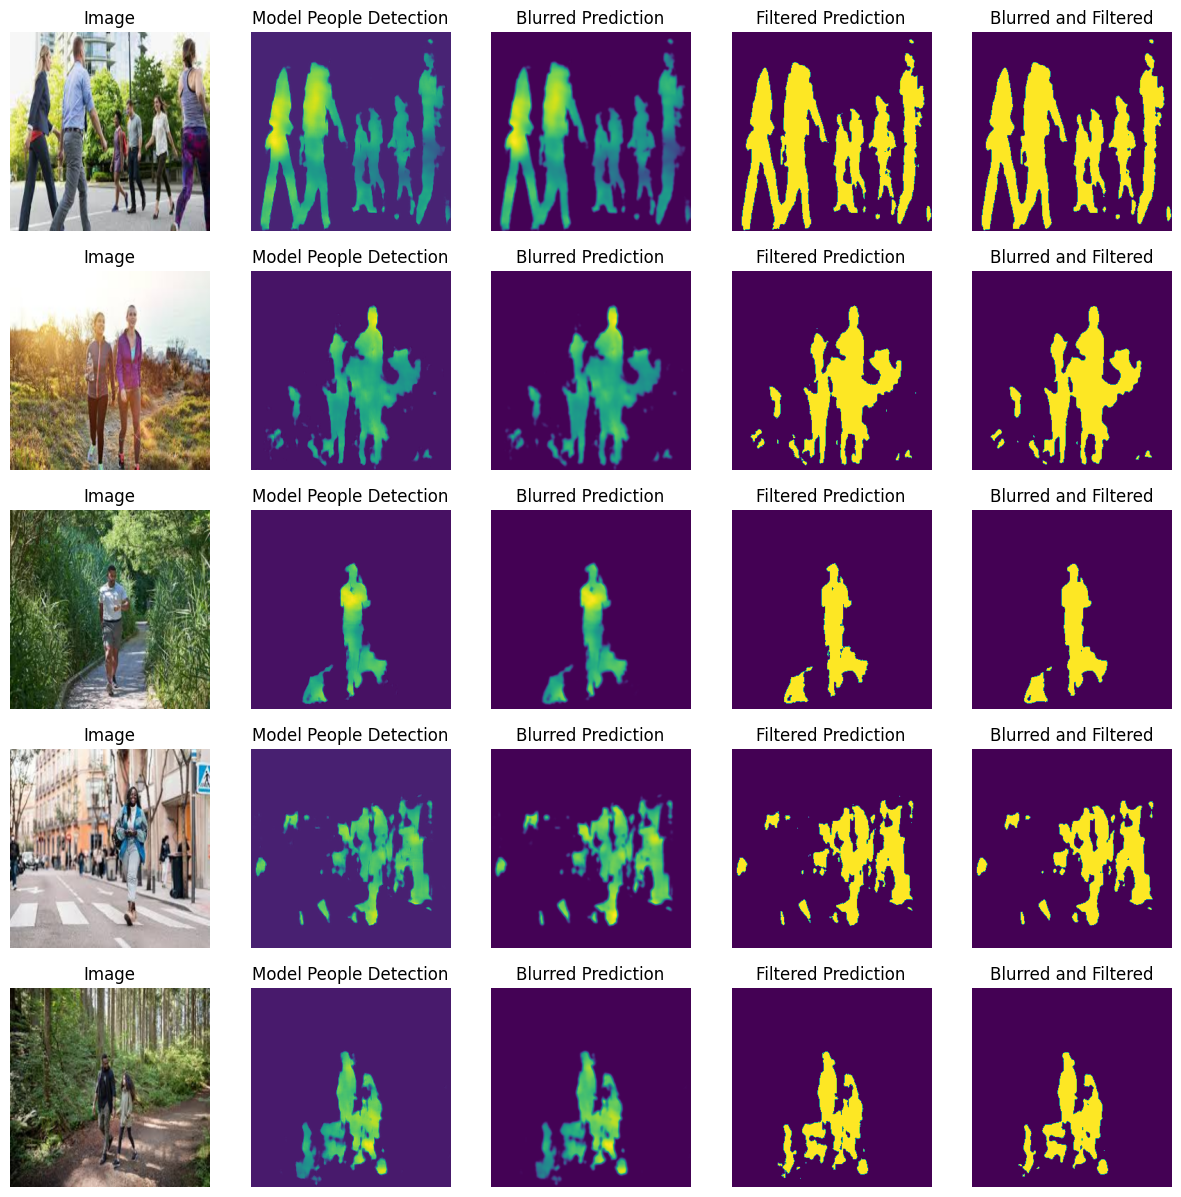

In [48]:
rows  = 5
col = 5

fig, axes = plt.subplots(rows, col, figsize=(col*3, rows*3))

index=0
for row_num in range(rows):
  # index+=1
  picture = test_torch[index].to('cpu')
  picture = picture.detach().numpy()
  picture = picture.transpose(1, 2, 0)

  picture = picture.astype(int)

  axes[row_num, 0].imshow(picture)
  axes[row_num, 0].set_title('Image')
  axes[row_num, 0].axis('off')

  pred_mask = test_pred_np[index].copy()

  axes[row_num, 1].imshow(pred_mask)
  axes[row_num, 1].set_title('Model People Detection')
  axes[row_num, 1].axis('off')

  threshold = 100
  new_pred = pred_mask.copy()
  blurred_pred = cv2.GaussianBlur(new_pred, (5,5), sigmaX=0)

  axes[row_num, 2].imshow(blurred_pred)
  axes[row_num, 2].set_title('Blurred Prediction')
  axes[row_num, 2].axis('off')

  # new_pred = blurred_pred.copy()
  new_pred[new_pred < threshold] = 0
  new_pred[new_pred > 1] = 255

  axes[row_num, 3].imshow(new_pred)
  axes[row_num, 3].set_title('Filtered Prediction')
  axes[row_num, 3].axis('off')

  blurred_pred[blurred_pred < threshold] = 0
  blurred_pred[blurred_pred > 1] = 255

  axes[row_num, 4].imshow(blurred_pred)
  axes[row_num, 4].set_title('Blurred and Filtered')
  axes[row_num, 4].axis('off')

  index+=1